In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.preprocessing import image
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

print(os.listdir("../input"))

Using TensorFlow backend.


['aerial-cactus-identification', 'trans-learn-weights']


In [2]:
''' train_path '''
train_path = '../input/aerial-cactus-identification/train/train'

''' test_path'''
test_path = '../input/aerial-cactus-identification/test/test'

''' reading csv file'''
df = pd.read_csv('../input/aerial-cactus-identification/train.csv')

X_train = df.id
y_train = df.has_cactus

print('total row and column of data =' + str(df.shape[0:]))
print('total image with cactus count =',sum(y_train == 1))
df.head()

total row and column of data =(17500, 2)
total image with cactus count = 13136


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
'''conversion of has_Cactus from int to string so that it can fit train_generator'''
labels.has_cactus = labels.has_cactus.astype(str)

''' Data Augmentation '''
train_ds = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip = True, fill_mode='nearest')

''' flow from directory '''
train_ds = train_ds.flow_from_dataframe(dataframe = df[:13500], directory = train_path, x_col = 'id', y_col = 'has_cactus',
    target_size = (128,128), color_mode = 'rgb', class_mode = 'binary')

val_ds = ImageDataGenerator(rescale = 1./255)

val_ds = val_ds.flow_from_dataframe(dataframe=df[13500:], directory = train_path, x_col = 'id', y_col = 'has_cactus',
    target_size = (128,128), color_mode = 'rgb', class_mode = 'binary')

Found 13500 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [4]:
''' Model VGG16'''
model1 = VGG16(include_top = False,weights =None,input_shape =(128,128,3))
model1.load_weights('../input/trans-learn-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
''' lets see how vgg model looks like '''
model1.summary()

Found 4000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None

In [6]:
''' container '''
model = Sequential()

''' adding vgg layer '''
model.add(base_model)
''' flattening output'''
model.add(Flatten())
''' Hidden Layer '''
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.5))
''' Classificaion Layer '''
model.add(Dense(1,activation = 'sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
''' lets see how original model looks like '''
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
for i in range (len(model1.layers)):
    print (i,model1.layers[i])

0 <keras.engine.input_layer.InputLayer object at 0x7fb099cf3ef0>
1 <keras.layers.convolutional.Conv2D object at 0x7fb09a498b70>
2 <keras.layers.convolutional.Conv2D object at 0x7fb09a498d68>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fb099bc25c0>
4 <keras.layers.convolutional.Conv2D object at 0x7fb099bc2160>
5 <keras.layers.convolutional.Conv2D object at 0x7fb099a303c8>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fb099a49a90>
7 <keras.layers.convolutional.Conv2D object at 0x7fb099a495f8>
8 <keras.layers.convolutional.Conv2D object at 0x7fb099b7c2b0>
9 <keras.layers.convolutional.Conv2D object at 0x7fb099b8ac88>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fb099b45550>
11 <keras.layers.convolutional.Conv2D object at 0x7fb099b45400>
12 <keras.layers.convolutional.Conv2D object at 0x7fb099af9208>
13 <keras.layers.convolutional.Conv2D object at 0x7fb099b0c828>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fb099aa6c50>
15 <keras.layers.convolutional.Conv2D object at 

In [9]:
''' freezing layers '''
for layer in model1.layers[11:]:
    layer.trainable=True
    
''' unfreezing layers '''
for layer in model1.layers[0:11]:
    layer.trainable=False
print('Unfreezed base model')

Unfreezed base model


In [10]:
epochs=8
batch_size=128

'''Using learning rate annealer'''
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, verbose=1)

In [11]:
''' compile the model '''
model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

print('model compiled')

model compiled


In [12]:
''' training '''
history = model.fit_generator(train_generator, callbacks = [red_lr],
                              epochs = epochs, validation_data = val_generator, validation_steps = 50,
                              verbose = 1, steps_per_epoch= math.ceil(labels.shape[0]/ batch_size))

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
137/137 [==============================] - 979s 7s/step - loss: 0.2082 - acc: 0.9133 - val_loss: 0.0948 - val_acc: 0.9575
Epoch 2/8
137/137 [==============================] - 980s 7s/step - loss: 0.0884 - acc: 0.9690 - val_loss: 0.0706 - val_acc: 0.9812
Epoch 3/8
137/137 [==============================] - 992s 7s/step - loss: 0.0797 - acc: 0.9747 - val_loss: 0.0314 - val_acc: 0.9888
Epoch 4/8
137/137 [==============================] - 987s 7s/step - loss: 0.0687 - acc: 0.9756 - val_loss: 0.0740 - val_acc: 0.9744
Epoch 5/8
137/137 [==============================] - 987s 7s/step - loss: 0.0527 - acc: 0.9820 - val_loss: 0.0380 - val_acc: 0.9881

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 6/8
137/137 [==============================] - 986s 7s/step - loss: 0.0424 - acc: 0.9847 - val_loss: 0.0637 - val_acc: 0.9750
Epoch 7/8
137/137 [==============================] - 986s 7s/step - loss: 0.037

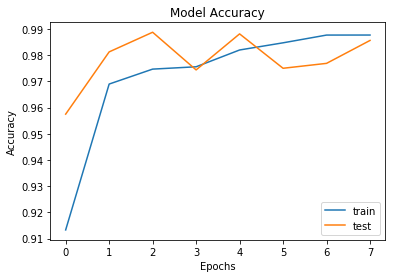

In [13]:
''' plotting training accuracy and validation accuracy '''
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

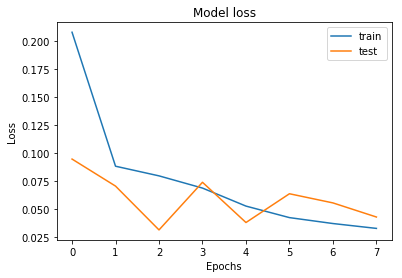

In [14]:
''' plotting training loss and validation loss '''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
''' reading test file '''
test_df = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')

''' Image data generator '''
test_ds = ImageDataGenerator(rescale = 1./255)

tes_ds = test_ds.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col = 'id', y_col = 'has_cactus',
    target_size = (128,128), color_mode = 'rgb', class_mode = 'other', shuffle = False)

''' prediction '''
predict = model.predict_generator(test_ds,steps = test_df.shape[0],verbose = 1)

Found 4000 images.
4000/4000 [==============================] - 13321s 3s/step


In [18]:
''' printing predicted value '''
print(predict)

''' reading file '''
y_df = pd.read_csv('../input/aerial-cactus-identification/sample_submission.csv')
count = 0

while (count <= y_df.shape[0]):
    y_df.has_cactus[count] = predict[count]
    count += 1
    if(count % 100 == 0):
        print('done 100 copies'+str(count))
    if(count % 4000 == 0):
        break
y_df.to_csv('submission.csv',index=False)

[[0.99999964]
 [1.        ]
 [0.0051342 ]
 ...
 [0.9999994 ]
 [1.        ]
 [1.        ]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


done 100 copies100
done 100 copies200
done 100 copies300
done 100 copies400
done 100 copies500
done 100 copies600
done 100 copies700
done 100 copies800
done 100 copies900
done 100 copies1000
done 100 copies1100
done 100 copies1200
done 100 copies1300
done 100 copies1400
done 100 copies1500
done 100 copies1600
done 100 copies1700
done 100 copies1800
done 100 copies1900
done 100 copies2000
done 100 copies2100
done 100 copies2200
done 100 copies2300
done 100 copies2400
done 100 copies2500
done 100 copies2600
done 100 copies2700
done 100 copies2800
done 100 copies2900
done 100 copies3000
done 100 copies3100
done 100 copies3200
done 100 copies3300
done 100 copies3400
done 100 copies3500
done 100 copies3600
done 100 copies3700
done 100 copies3800
done 100 copies3900
done 100 copies4000


In [19]:
''' displaying first five rows '''
y_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.000000
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.005134
3,002e175c3c1e060769475f52182583d0.jpg,0.007958
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.999952
